<a href="https://colab.research.google.com/github/invite-you/test/blob/master/load_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def rotate_init_box(bb, cx, cy, theta):
    new_bb = list(bb)
    for i,coord in enumerate(bb):
        # opencv calculates standard transformation matrix
        M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
        # Grab  the rotation components of the matrix)
        # Prepare the vector to be transformed
        v = [coord[0],coord[1],1]
        # Perform the actual rotation and return the image
        calculated = np.dot(M,v)
        new_bb[i] = (calculated[0],calculated[1])
    return new_bb

def convert_bbox_to_rbox(cx, cy, h, w, theta):
    x1, y1, x3, y3 = cx-(w/2), cy-(h/2), cx+(w/2), cy+(h/2)
    x4, y4, x2, y2 = cx-(w/2), cy+(h/2), cx+(w/2), cy-(h/2)
    bbox = [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
   
    rbox = rotate_init_box(bbox, cx, cy, -theta)
    return rbox

def rotate_box(bb, cx, cy, h, w, theta):
    new_bb = list(bb)
    for i,coord in enumerate(bb):
        # opencv calculates standard transformation matrix
        M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
        # Prepare the vector to be transformed
        v = [coord[0],coord[1],1]
        # Perform the actual rotation and return the image
        calculated = np.dot(M,v)
        new_bb[i] = (calculated[0],calculated[1])
    return new_bb

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    #M[0, 2] += (nW / 2) - cX
    #M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

def diff_baseline_image(points, base):
    points = np.array(points)
    padding = 0
    #print("smallest: ", points[points < 0])
    #print("biggest: ", points[base < points])

    if (not len(points[base < points]) == 0) and (not len(points[points < 0]) == 0):
        print("What??? small image")
        return 0
    diff=0
    over = points[base < points]
    if not 0 == len(over):
        diff = max(over) - base + padding

    over = points[points < 0]
    if not 0 == len(over):
        diff = min(over) - padding
    return -diff      

def move_inside_rbbox(image, rbbox):
    # 이미지 회전 후 bbox가 이미지 사이즈보다 더 커지는 경우 방지
    # bbox가 이미지 사이즈 보다 크거나 작을 경우 사이즈를 옮긴다
    xs = [box[0] for box in rbbox]
    ys = [box[1] for box in rbbox]

    x_diff = diff_baseline_image(xs, image.shape[0])
    y_diff = diff_baseline_image(ys, image.shape[1])

    # 변환 행렬, X축으로 10, Y축으로 20 이동
    M = np.float32([[1,0,x_diff],[0,1,y_diff]])
    (heigth, width) = image.shape[:2]
    rimage = cv2.warpAffine(image, M,(width, heigth))

    rbbox = [[x+x_diff, y+y_diff] for x, y in zip(xs, ys)]
    return rimage, rbbox

def get_label(idx):
    minX, minY = rbboxs[idx]['rbbox']['minX'], rbboxs[idx]['rbbox']['minY']
    maxX, maxY = rbboxs[idx]['rbbox']['maxX'], rbboxs[idx]['rbbox']['maxY']
    label = rbboxs[idx]['rbbox']['label']

    return minX, minY, maxX, maxY, label

def get_image(idx):
    x_diff, y_diff = rbboxs[idx]['image_param']['x_diff'], rbboxs[idx]['image_param']['y_diff']
    theta, fileidx = rbboxs[idx]['image_param']['theta'], rbboxs[idx]['image_param']['fileidx']
    image = np.array(Image.open(images[fileidx]))
    # 이미지 돌리기
    image = rotate_bound(image, theta)
    # 이미지 이동
    (heigth, width) = 768, 768 #image.shape[:2]
    print(heigth, width)
    M = np.float32([[1,0,x_diff],[0,1,y_diff]])
    image = cv2.warpAffine(image, M, (width, heigth))

    return image


In [112]:
import os
import pickle
import numpy as np
from skimage.io import imread

import io
import numpy as np
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
import math
import pandas as pd

info_file = "/content/gdrive/My Drive/findShip/test.pickle" 

with open(info_file, 'rb') as f:
    info = pickle.load(f)


len(info)

1945

In [113]:
import pandas as pd
import math

idx = 3

def rotate_init_box(bb, cx, cy, theta):
    new_bb = list(bb)
    for i,coord in enumerate(bb):
        # opencv calculates standard transformation matrix
        M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
        # Grab  the rotation components of the matrix)
        # Prepare the vector to be transformed
        v = [coord[0],coord[1],1]
        # Perform the actual rotation and return the image
        calculated = np.dot(M,v)
        new_bb[i] = (calculated[0],calculated[1])
    return new_bb


def convert_bbox_to_rbox(cx, cy, h, w, theta):
    x1, y1, x3, y3 = cx-(w/2), cy-(h/2), cx+(w/2), cy+(h/2)
    x4, y4, x2, y2 = cx-(w/2), cy+(h/2), cx+(w/2), cy-(h/2)
    bbox = [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
    
    rbox = rotate_init_box(bbox, cx, cy, -theta)
    
    return rbox

src_dir = "/content/gdrive/My Drive/findShip/"

annots = []

for idx in range(len(info)):
    image_id = info[idx]['image_filename']
    filename = "_".join([image_id.replace(".png", ''), str(info[idx]['row']), str(info[idx]['col'])]) + '.png'
    #image = imread(os.path.join(src_dir, 'patch_images/', filename))


    cxs, cys = info[idx]['center_xs'], info[idx]['center_ys']
    hs, ws = info[idx]['heights'], info[idx]['widths']
    thetas, labels = info[idx]['thetas'], info[idx]['class_indices']
    annot = {'image_filename': None,
            'bboxes' : []
            }
    annot['image_filename'] = filename
    for cx, cy, h, w, theta, label in zip(cxs, cys, hs, ws, thetas, labels):
        (heigth, width) = 1024, 1024#image.shape[:2]

        theta= math.degrees(theta)
        cy = cy * heigth
        cx = cx * width
        h = h *heigth
        w = w * width

        rbox = convert_bbox_to_rbox(cx, cy, h, w, theta)
        at = {}
        at['bbox'] = rbox
        at['label'] = label
        annot['bboxes'].append(at)
        #cv2.rectangle(image, (int(min_p[0]), int(min_p[1])), (int(max_p[0]), int(max_p[1])), (0, 0, 255), 2 )
    annots.append(annot)
    #cv2_imshow(image)

info_file = "/content/gdrive/My Drive/findShip/polygon_test.pickle" 

with open(info_file, 'wb') as f:
    pickle.dump(annots, f)


len(info)

1945

In [86]:
import pandas as pd
import math

idx = 3

def rotate_init_box(bb, cx, cy, theta):
    new_bb = list(bb)
    for i,coord in enumerate(bb):
        # opencv calculates standard transformation matrix
        M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
        # Grab  the rotation components of the matrix)
        # Prepare the vector to be transformed
        v = [coord[0],coord[1],1]
        # Perform the actual rotation and return the image
        calculated = np.dot(M,v)
        new_bb[i] = (calculated[0],calculated[1])
    return new_bb


def convert_bbox_to_rbox(cx, cy, h, w, theta):
    x1, y1, x3, y3 = cx-(w/2), cy-(h/2), cx+(w/2), cy+(h/2)
    x4, y4, x2, y2 = cx-(w/2), cy+(h/2), cx+(w/2), cy-(h/2)
    bbox = [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
    
    rbox = rotate_init_box(bbox, cx, cy, -theta)
    rbox = np.array(rbox)

    xs = rbox[:,0]
    ys = rbox[:,1]
    max_p = [max(xs), max(ys)]
    min_p = [min(xs), min(ys)]

    """
    xy = pd.DataFrame(data=rbox, columns=['x','y'])    
    min_p = xy.nsmallest(2, 'x').nsmallest(1, 'y').values[0].tolist()    
    max_p = xy.nlargest(2, 'y').nlargest(1, 'x').values[0].tolist()  
    """
    
    (heigth, width) = 1024, 1024

    if max_p[0] <= 0:
        max_p[0] = 1
    if width <= max_p[0]:
        max_p[0] = width - 1

    if max_p[1] <= 0:
        max_p[1] = 1
    if heigth <= max_p[1]:
        max_p[1] = heigth-1   
    
    return (min_p, max_p)

src_dir = "/content/gdrive/My Drive/findShip/"

annots = []

for idx in range(len(info)):
    image_id = info[idx]['image_filename']
    filename = "_".join([image_id.replace(".png", ''), str(info[idx]['row']), str(info[idx]['col'])]) + '.png'
    #image = imread(os.path.join(src_dir, 'patch_images/', filename))


    cxs, cys = info[idx]['center_xs'], info[idx]['center_ys']
    hs, ws = info[idx]['heights'], info[idx]['widths']
    thetas, labels = info[idx]['thetas'], info[idx]['class_indices']
    annot = {'image_filename': None,
            'bboxes' : []
            }
    annot['image_filename'] = filename
    for cx, cy, h, w, theta, label in zip(cxs, cys, hs, ws, thetas, labels):
        (heigth, width) = 1024, 1024#image.shape[:2]

        theta= math.degrees(theta)
        cy = cy * heigth
        cx = cx * width
        h = h *heigth
        w = w * width

        min_p, max_p = convert_bbox_to_rbox(cx, cy, h, w, theta)
        at = {}
        at['minX'] = min_p[0]
        at['minY'] = min_p[1]
        at['maxX'] = max_p[0]
        at['maxY'] = max_p[1]
        at['label'] = label
        annot['bboxes'].append(at)
        #cv2.rectangle(image, (int(min_p[0]), int(min_p[1])), (int(max_p[0]), int(max_p[1])), (0, 0, 255), 2 )
    annots.append(annot)
    #cv2_imshow(image)

info_file = "/content/gdrive/My Drive/findShip/no_turn_train.pickle" 

with open(info_file, 'wb') as f:
    pickle.dump(annots, f)


len(info)

ValueError: ignored

In [19]:
annotations

{'bboxes': array([[700.34168404, 938.82174542, 945.59972221, 999.37552021],
        [778.68359667, 817.83440906, 904.1660127 , 953.80157727]]),
 'labels': array([4, 4], dtype=int32)}

In [0]:
index = 
annotations = {'labels': np.empty((0,), dtype=np.int32), 'bboxes': np.empty((0, 4))}

bboxes = annots[index]['bboxes']
for i, bbox in enumerate(bboxes):
    annotations['labels'] = np.concatenate((annotations['labels'], [bbox['label']]))
    annotations['bboxes'] = np.concatenate((annotations['bboxes'], [[
        bbox['minX'],
        bbox['minY'],
        bbox['maxX'],
        bbox['maxY'],
    ]]))

In [45]:
annots[:2]

[{'bbox': [{'label': 4,
    'maxX': 945.5997222107299,
    'maxY': 999.3755202056993,
    'minX': 700.3416840392701,
    'minY': 938.8217454193006},
   {'label': 4,
    'maxX': 904.1660127031003,
    'maxY': 953.8015772696167,
    'minX': 778.6835966718996,
    'minY': 817.8344090585085}],
  'image_filename': '0_1024_1536.png'},
 {'bbox': [{'label': 4,
    'maxX': 433.5997222107298,
    'maxY': 999.3755202056993,
    'minX': 188.3416840392702,
    'minY': 938.8217454193006},
   {'label': 4,
    'maxX': 392.16601270310025,
    'maxY': 953.8015772696167,
    'minX': 266.6835966718997,
    'minY': 817.8344090585085},
   {'label': 4,
    'maxX': 748.5850700998944,
    'maxY': 781.8992270174851,
    'minX': 487.53016427510545,
    'minY': 703.596866732515},
   {'label': 4,
    'maxX': 602.8692689359372,
    'maxY': 889.6175559372604,
    'minX': 462.89049668906284,
    'minY': 821.6732155471144},
   {'label': 4,
    'maxX': 774.6236718097938,
    'maxY': 847.9145958129027,
    'minX': 506.3

In [4]:
info[3]

{'center_xs': [0.3036823272705078,
  0.2093358039855957,
  0.3217039108276367,
  0.603571891784668,
  0.11013603210449219,
  0.520390510559082,
  0.6254899501800537,
  0.6324977874755859],
 'center_ys': [0.44638538360595703,
  0.496822714805603,
  0.3650566339492798,
  0.2253398895263672,
  0.6031181812286377,
  0.335591197013855,
  0.2836116552352905,
  0.11538445949554443],
 'class_indices': [4, 4, 4, 4, 4, 4, 4, 4],
 'class_texts': ['maritime vessels',
  'maritime vessels',
  'maritime vessels',
  'maritime vessels',
  'maritime vessels',
  'maritime vessels',
  'maritime vessels',
  'maritime vessels'],
 'col': 2048,
 'heights': [0.04794453829526901,
  0.029971621930599213,
  0.03456564247608185,
  0.036764178425073624,
  0.038271352648735046,
  0.04607628285884857,
  0.03942437842488289,
  0.045360416173934937],
 'image_filename': '0.png',
 'patch_height': 1024,
 'patch_size': 1024,
 'patch_width': 1024,
 'row': 1536,
 'thetas': [0.04735859419071558,
  0.04735633050378901,
  0.850

In [0]:
def get_patch_image(image, row, col, patch_size):
    patch_image_height = patch_size if image.shape[0] - row > patch_size else image.shape[0] - row
    patch_image_width = patch_size if image.shape[1] - col > patch_size else image.shape[1] - col

    patch_image = image[row: row + patch_image_height, col: col + patch_image_width]
    
    if patch_image_height < patch_size or patch_image_width < patch_size:
        pad_height = patch_size - patch_image_height
        pad_width = patch_size - patch_image_width
        patch_image = np.pad(patch_image, ((0, pad_height), (0, pad_width), (0, 0)), 'constant')
    
    return patch_image

In [0]:
patch_image.shape[:2]

(1024, 1024)

In [0]:

src_dir = '/content/gdrive/My Drive/findShip/'

dst_dir = '/content/gdrive/My Drive/findShip/patch_images/'

info_files = ["/content/gdrive/My Drive/findShip/no_turn_train.pickle", "/content/gdrive/My Drive/findShip/no_turn_test.pickle"]

for info_file in info_files:

    with open(info_file, 'rb') as f:
        info = pickle.load(f)

    for idx in range(len(info)):
        image_id = info[idx]['image_filename']
        row = info[idx]['row']
        col = info[idx]['col']
        patch_size = info[idx]['patch_size']


        image = imread(os.path.join(src_dir, 'images/', image_id))
        patch_image = get_patch_image(image, row, col, patch_size)
        patch_image = cv2.cvtColor(patch_image, cv2.COLOR_BGR2RGB)
        #cv2_imshow(patch_image)

        hi, wi = patch_image.shape[:2]
        if not hi == 1024: print("???", os.path.join(src_dir, 'images/', image_id) )
        if not wi == 1024: print("???", os.path.join(src_dir, 'images/', image_id) )

        filename = "_".join([image_id.replace(".png", ''), str(row), str(col)]) + '.png'
        cv2.imwrite(os.path.join(dst_dir, filename ), patch_image)
        if not os.path.isfile(os.path.join(dst_dir, filename )):
            print("ERROR!!")
            print(os.path.join(dst_dir, filename ))

        #if idx == 0: break
        if idx%100 == 0:
            print(idx)
    #break



7100
7200
7300
7400
7500
7600
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [0]:

src_dir = '/content/gdrive/My Drive/findShip/'
rbboxs = []
image_container = []

for idx in range(len(info)):
    
    image_id = info[idx]['image_filename']
    row = info[idx]['row']
    col = info[idx]['col']
    patch_size = info[idx]['patch_size']

    image = imread(os.path.join(src_dir, 'images/', image_id))
    patch_image = get_patch_image(image, row, col, patch_size)

    try:
        image_container[idx]
    except IndexError:
        image_container.append(patch_image)

    cxs, cys = info[idx]['center_xs'], info[idx]['center_ys']
    hs, ws = info[idx]['heights'], info[idx]['widths']
    thetas, labels = info[idx]['thetas'], info[idx]['class_indices']

    for cx, cy, h, w, theta, label in zip(cxs, cys, hs, ws, thetas, labels):

        (heigth, width) = patch_image.shape[:2]
        (imgcX, imgcY) = (width // 2, heigth // 2)
        theta= math.degrees(theta)

        cy = cy * heigth
        cx = cx * width
        h = h *heigth
        w = w * width

        rbox = convert_bbox_to_rbox(cx, cy, h, w, theta)

        rbbox = rotate_box(rbox, imgcX, imgcY, heigth, width, theta)
        rimage = rotate_bound(patch_image, theta)

        # 이미지 회전 후 bbox가 이미지 사이즈보다 더 커지는 경우 방지
        # bbox가 이미지 사이즈 보다 크거나 작을 경우 사이즈를 옮긴다
        xs = [box[0] for box in rbbox]
        ys = [box[1] for box in rbbox]

        x_diff = diff_baseline_image(xs, width)
        y_diff = diff_baseline_image(ys, heigth)

        rbbox = [[x+x_diff, y+y_diff] for x, y in zip(xs, ys)]

        xy = pd.DataFrame(data=rbbox, columns=['x','y'])
        xy1 = xy.nsmallest(2, 'x').nsmallest(1, 'y').values[0].tolist()    
        xy2 = xy.nlargest(2, 'y').nlargest(1, 'x').values[0].tolist()  


        if xy1[0] <= 0:
            xy1[0] = 1
        if width <= xy2[0]:
            xy2[0] = width - 1

        if xy1[1] <= 0:
            xy1[1] = 1
        if heigth <= xy2[1]:
            xy2[1] = heigth-1
            
        """
        print(image_features['image/filename'], image.shape) 
        print("rbbox: ", rbbox)
        print("rimage shape: ", image.shape)

        print("xy, xy", xy1, xy2)
        print("image index:", image_idx)
        """
        rbboxs.append(
            {"image_param": {'x_diff': x_diff, 'y_diff': y_diff,
                            'theta': theta, 'fileidx': idx},
            "rbbox": {'minX': xy1[0], 'minY': xy1[1],
                        'maxX': xy2[0], 'maxY': xy2[1],
                        'label': label}
            })
        
        """
        mn = [int(x) for x in xy1]
        mx = [int(x) for x in xy2]

        print("rbbox: ", rbbox)
        print("rimage shape: ", rimage.shape)
        print((mn[0], mn[1]), (mx[0], mx[1]))


        cv2.rectangle(rimage, (mn[0], mn[1]), (mx[0], mx[1]), (0, 0, 255), 2 )
        cv2_imshow(rimage)
        """

What??? small image
What??? small image
What??? small image
What??? small image
What??? small image
What??? small image


In [0]:

idx = 0

for idx in range(len(info)):
src_dir = '/content/gdrive/My Drive/findShip/'

image_id = info[idx]['image_filename']
row = info[idx]['row']
col = info[idx]['col']
patch_size = info[idx]['patch_size']

image = imread(os.path.join(src_dir, 'images/', image_id))
patch_image = get_patch_image(image, row, col, patch_size)




cxs, cys = info[idx]['center_xs'], info[idx]['center_ys']
hs, ws = info[idx]['heights'], info[idx]['widths']
thetas, labels = info[idx]['thetas'], info[idx]['class_indices']

for cx, cy, h, w, theta, label in zip(cxs, cys, hs, ws, thetas, labels):

    (heigth, width) = patch_image.shape[:2]
    (imgcX, imgcY) = (width // 2, heigth // 2)
    theta= math.degrees(theta)

    cy = cy * heigth
    cx = cx * width
    h = h *heigth
    w = w * width

    rbox = convert_bbox_to_rbox(cx, cy, h, w, theta)

    rbbox = rotate_box(rbox, imgcX, imgcY, heigth, width, theta)
    rimage = rotate_bound(patch_image, theta)

    # 이미지 회전 후 bbox가 이미지 사이즈보다 더 커지는 경우 방지
    # bbox가 이미지 사이즈 보다 크거나 작을 경우 사이즈를 옮긴다
    xs = [box[0] for box in rbbox]
    ys = [box[1] for box in rbbox]

    x_diff = diff_baseline_image(xs, width)
    y_diff = diff_baseline_image(ys, heigth)

    rbbox = [[x+x_diff, y+y_diff] for x, y in zip(xs, ys)]

    xy = pd.DataFrame(data=rbbox, columns=['x','y'])
    xy1 = xy.nsmallest(2, 'x').nsmallest(1, 'y').values[0].tolist()    
    xy2 = xy.nlargest(2, 'y').nlargest(1, 'x').values[0].tolist()  


    if xy1[0] <= 0:
        xy1[0] = 1
    if width <= xy2[0]:
        xy2[0] = width - 1

    if xy1[1] <= 0:
        xy1[1] = 1
    if heigth <= xy2[1]:
        xy2[1] = heigth-1
        
    """
    print(image_features['image/filename'], image.shape) 
    print("rbbox: ", rbbox)
    print("rimage shape: ", image.shape)

    print("xy, xy", xy1, xy2)
    print("image index:", image_idx)
    """

    rbboxs.append(
    {"image": rimage,
    "rbbox": {'minX': xy1[0], 'minY': xy1[1],
                'maxX': xy2[0], 'maxY': xy2[1],
                'label': answer}
    })
    
    """
    mn = [int(x) for x in xy1]
    mx = [int(x) for x in xy2]

    print("rbbox: ", rbbox)
    print("rimage shape: ", rimage.shape)
    print((mn[0], mn[1]), (mx[0], mx[1]))


    cv2.rectangle(rimage, (mn[0], mn[1]), (mx[0], mx[1]), (0, 0, 255), 2 )
    cv2_imshow(rimage)
    """

In [0]:
cd /content

/content


In [4]:
!git clone https://github.com/invite-you/EfficientDet-1.git

Cloning into 'EfficientDet-1'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 447 (delta 119), reused 0 (delta 0), pack-reused 273
Receiving objects: 100% (447/447), 523.77 KiB | 975.00 KiB/s, done.
Resolving deltas: 100% (283/283), done.


In [34]:
!git pull origin master

remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
From https://github.com/invite-you/EfficientDet-1
 * branch            master     -> FETCH_HEAD
   9cb72ac..bcd45ee  master     -> origin/master
Updating 9cb72ac..bcd45ee
Fast-forward
 generators/pickle_.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)


In [14]:
cd /content/EfficientDet-1

/content/EfficientDet-1


In [15]:
from generators.pickle_ import PickleGenerator

In [77]:
from augmentor.color import VisualEffect
from augmentor.misc import MiscEffect

pickle_file = '/content/gdrive/My Drive/findShip/no_turn_test.pickle'

misc_effect = MiscEffect()
visual_effect = VisualEffect()

pg = PickleGenerator(pickle_file, turn=True, phi=4, misc_effect=misc_effect, visual_effect=visual_effect )

## all dataset:  1945


In [0]:
idx = 2
bbox = pg.load_annotations(idx)
image = pg.load_image(idx)
#cv2.rectangle(image, (int(min_p[0]), int(min_p[1])), (int(max_p[0]), int(max_p[1])), (0, 0, 255), 2 )

#cv2_imshow(image)


In [75]:
pg.image_size

512

/content/EfficientDet-1/generators/common.py:159: UserWarning: Image with id 1224 (shape (1024, 1024, 3)) contains the following invalid boxes: [[-33.27132925  63.52829794 119.47482046 170.2688212 ]
 [ -0.59716846  50.21831712 134.61108448 146.0089778 ]].
  annotations['bboxes'][invalid_indices, :]


(1024, 1024, 3)


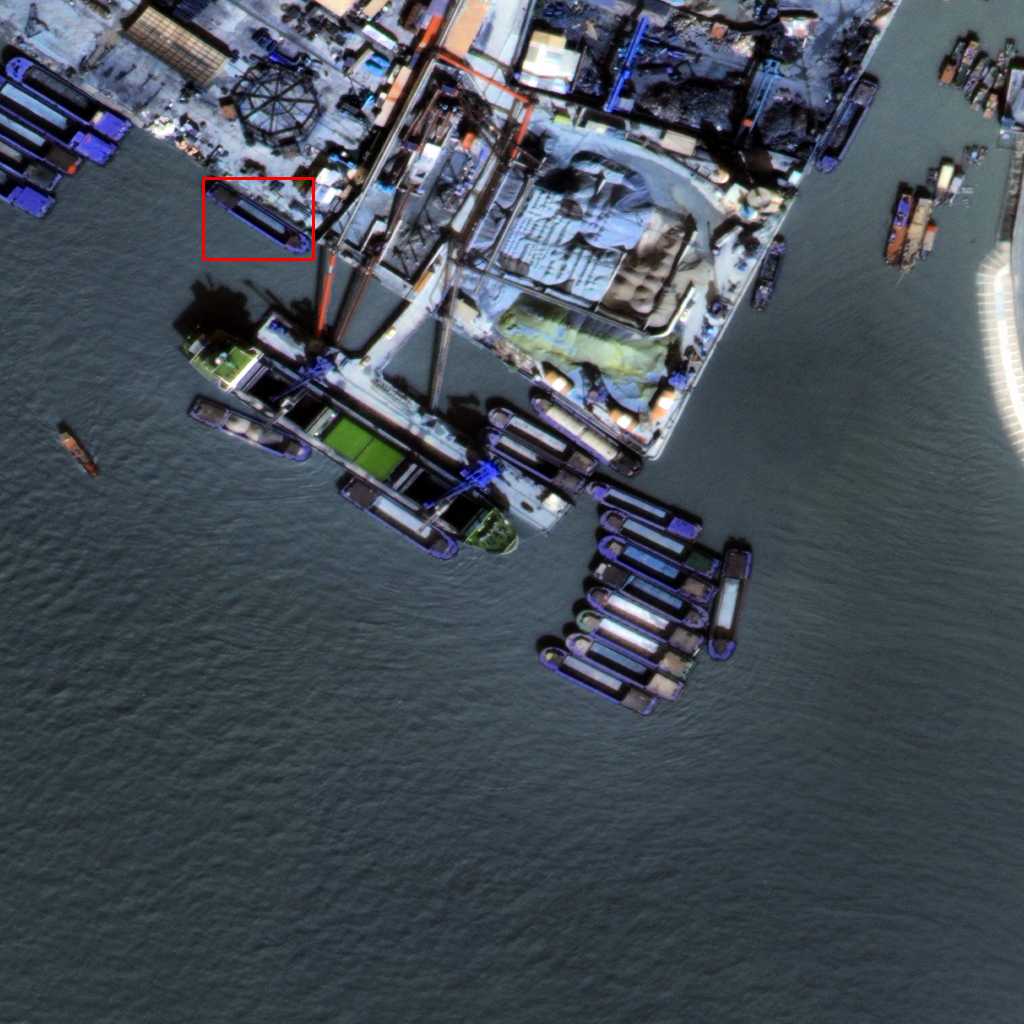

(1024, 1024, 3)


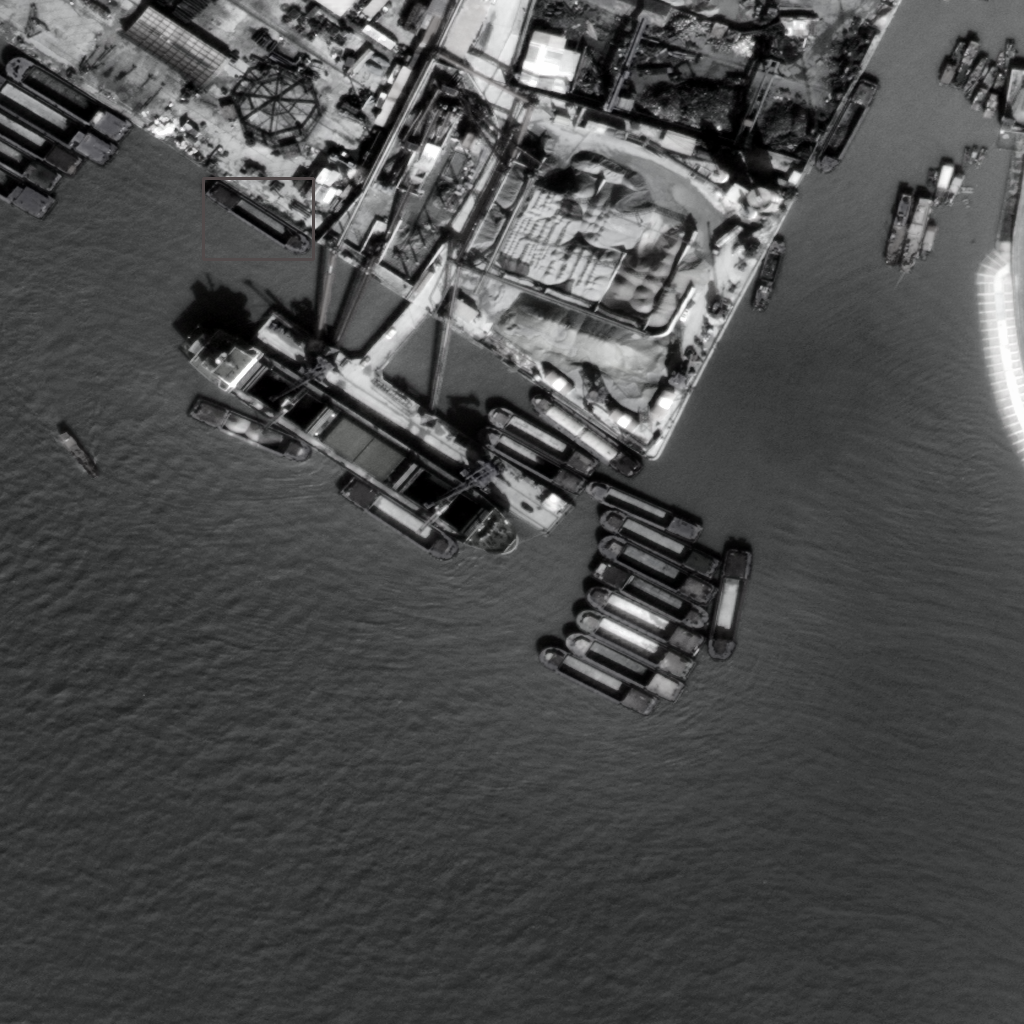

(1024, 1024, 3)


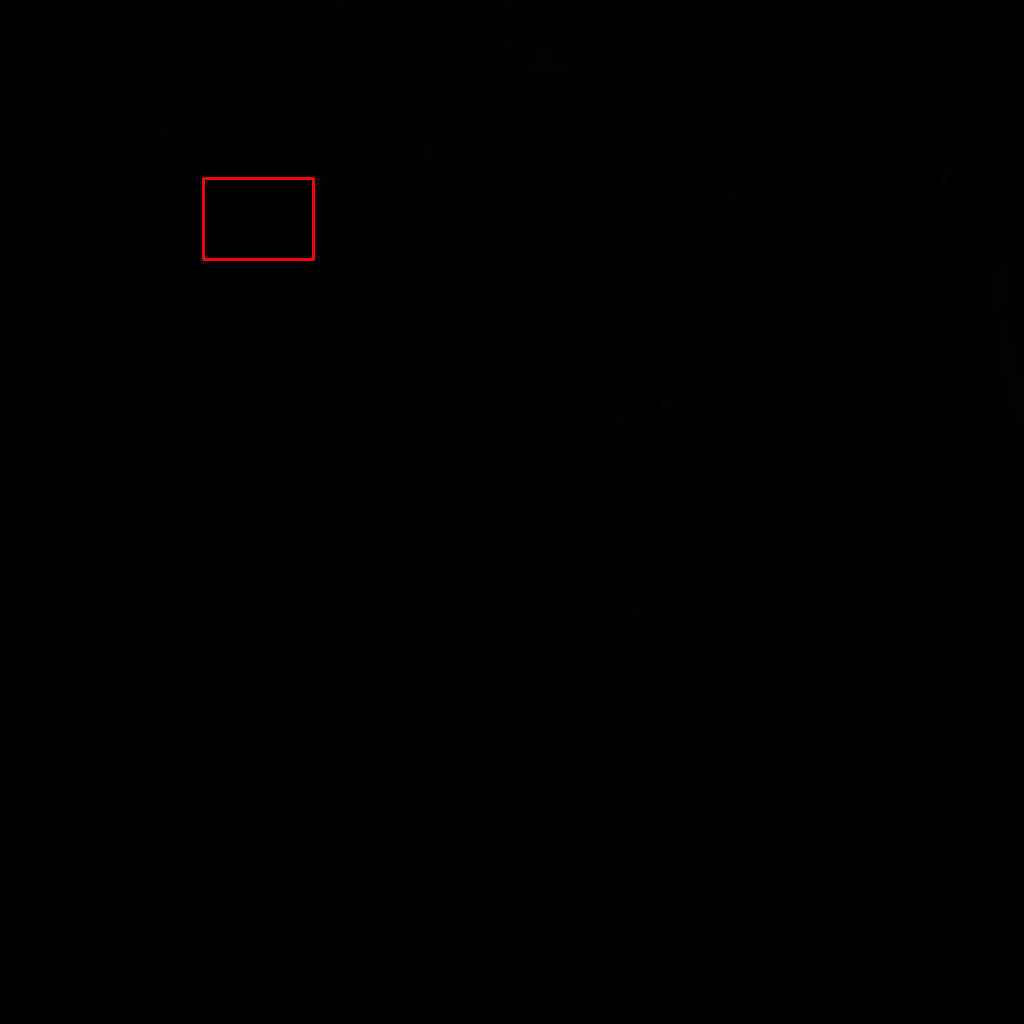

(1024, 1024, 3)


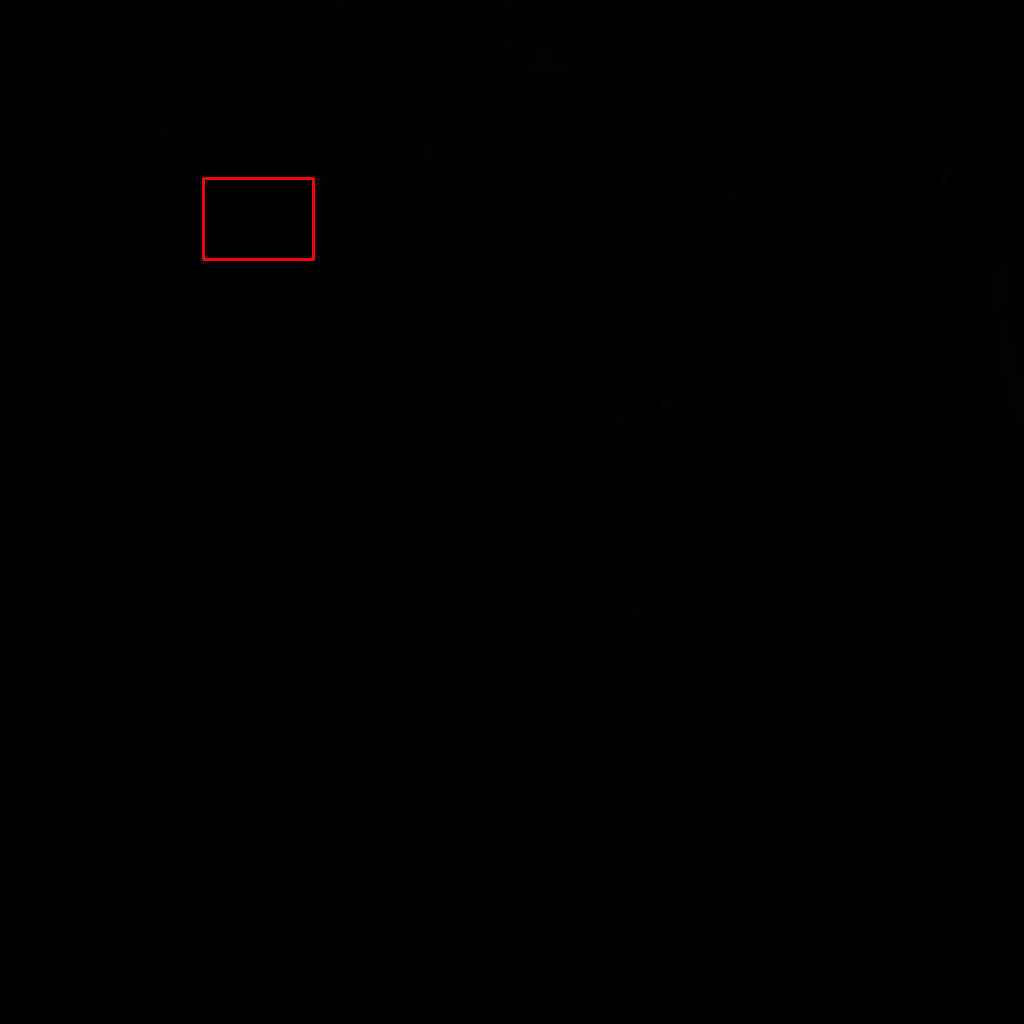

In [81]:
group = pg.groups[0]

# load images and annotations
# list
image_group = pg.load_image_group(group)
annotations_group = pg.load_annotations_group(group)


def print_image(image_group, annotations_group):
    
    image = image_group[0]
    print(image.shape)
    bx = annotations_group[0]['bboxes'][0]
    min_p= bx[:2]
    max_p = bx[2:]

    cv2.rectangle(image, (int(min_p[0]), int(min_p[1])), (int(max_p[0]), int(max_p[1])), (0, 0, 255), 2 )
    cv2_imshow(image)



# check validity of annotations
image_group, annotations_group = pg.filter_annotations(image_group, annotations_group, group)
print_image(image_group, annotations_group)
# randomly apply visual effect
image_group, annotations_group = pg.random_visual_effect_group(image_group, annotations_group)
print_image(image_group, annotations_group)
# randomly transform data
#image_group, annotations_group = pg.random_transform_group(image_group, annotations_group)

# randomly apply misc effect
#image_group, annotations_group = pg.random_misc_group(image_group, annotations_group)
#print_image(image_group, annotations_group)

# perform preprocessing steps
image_group, annotations_group = pg.preprocess_group(image_group, annotations_group)
print_image(image_group, annotations_group)
# check validity of annotations
image_group, annotations_group = pg.clip_transformed_annotations(image_group, annotations_group, group)
print_image(image_group, annotations_group)


In [51]:

if len(image_group) == 0:
    return None, None

# compute network inputs
inputs = self.compute_inputs(image_group, annotations_group)

# compute network targets
targets = self.compute_targets(image_group, annotations_group)

img = pg.load_image_group([1542])
annot = pg.load_annotations_group([1542])
print(annot)
cv2.rectangle(image, (int(min_p[0]), int(min_p[1])), (int(max_p[0]), int(max_p[1])), (0, 0, 255), 2 )
#cv2_imshow(img[0])

[1542]

In [0]:
 pg.compute_inputs_targets(pg.groups[1])

In [45]:
len(pg[0][1])

2

In [46]:
pg[0][1][0]

array([[[ 3.2370744 , 19.893236  ,  6.3837185 , 26.637682  ,
          0.        ],
        [ 3.0850165 , 16.30502   ,  4.551012  , 20.626593  ,
          0.        ],
        [ 2.9643278 , 13.457051  ,  3.0963922 , 15.855589  ,
          0.        ],
        ...,
        [-0.43101045,  0.7770708 , -4.554207  , -3.890434  ,
          0.        ],
        [-0.06102805,  1.2102758 , -4.2850814 , -3.516604  ,
          0.        ],
        [ 0.46731055,  1.4763452 , -3.91682   , -3.306879  ,
          0.        ]]], dtype=float32)

In [47]:
pg[0][1][1]

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]], dtype=float32)

In [34]:
bbox['bboxes'][0][2:]

array([350.14911014, 456.90020623])

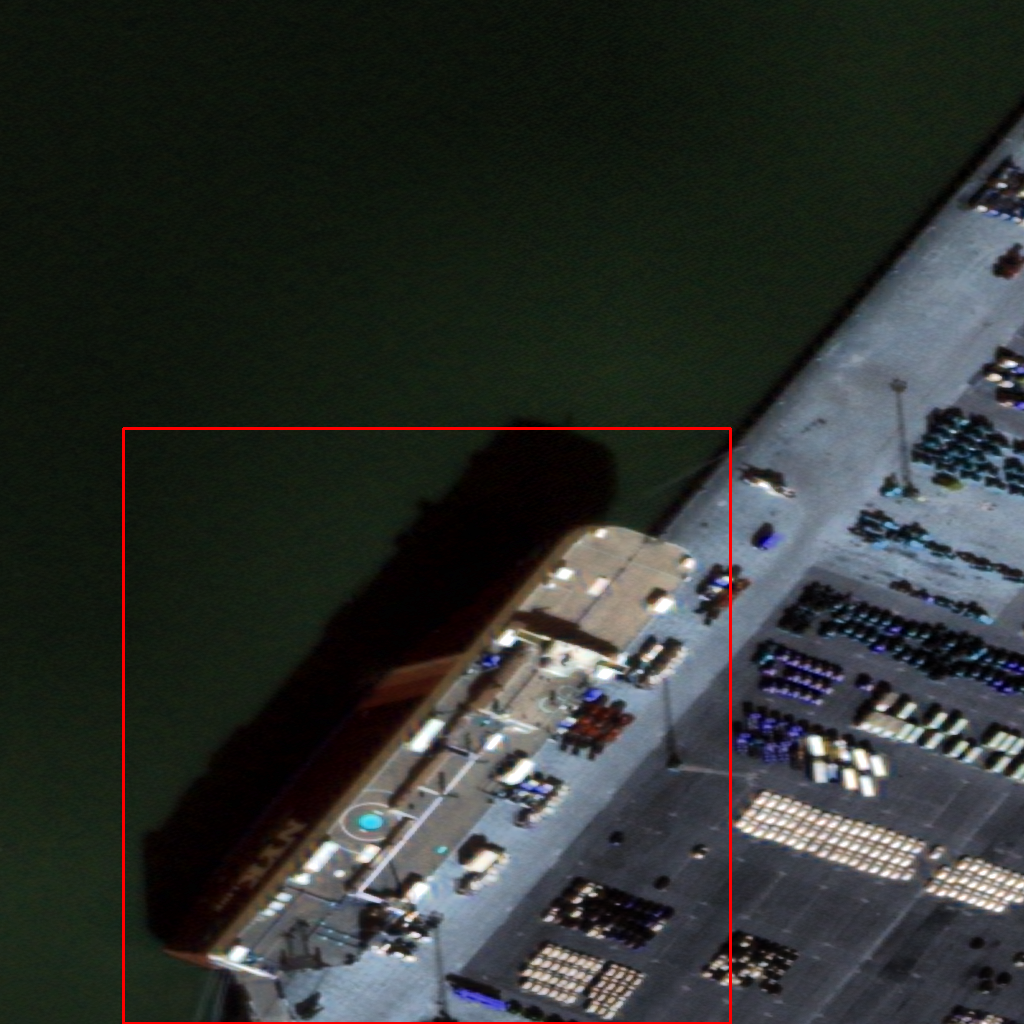

In [39]:
idx = 23
bbox = pg.load_annotations(idx)
image = pg.load_image(idx)

for bx in  bbox['bboxes']:
    min_p= bx[:2]
    max_p = bx[2:]
    cv2.rectangle(image, (int(min_p[0]), int(min_p[1])), (int(max_p[0]), int(max_p[1])), (0, 0, 255), 2 )

cv2_imshow(image)


In [0]:
PickleGenerator = None

In [0]:
import tensorflow as tf

def tf_bbox2mask(x1, y1, x2, y2, img_H, img_W):
    ## Repeat for each row or column
    y1_transposed = tf.expand_dims(tf.tile(y1,[img_W]), 0)
    x1_transposed = tf.expand_dims(tf.tile(x1,[img_H]), 1)
    y2_transposed = tf.expand_dims(tf.tile(y2,[img_W]), 0)
    x2_transposed = tf.expand_dims(tf.tile(x2,[img_H]), 1)
    ## Get the range grid
    range_row = tf.cast(tf.expand_dims(tf.range(0, img_H, 1), 1), tf.int32)
    range_col = tf.cast(tf.expand_dims(tf.range(0, img_W, 1), 0), tf.int32)
    ## Generate bollean masks
    mask_y1 = tf.less(y1_transposed, range_row)
    mask_x1 = tf.less(x1_transposed, range_col)
    mask_y2 = tf.less(range_row, y2_transposed)
    mask_x2 = tf.less(range_col, x2_transposed)

    result = tf.to_float(mask_y1)*tf.to_float(mask_x1)*tf.to_float(mask_y2)*tf.to_float(mask_x2)
    return result

In [0]:
tf.tile(23.234234,[1024])

In [120]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

Using TensorFlow backend.


In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['container', 'oil tanker', 'aircraft carrier', 'maritime vessels']
    
    def __init__(
            self, 
            base_dir,
            pickle_file,            
            #classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.base_dir = base_dir
        self.ids = os.listdir(images_dir)

        #file = "/content/gdrive/My Drive/findShip/polygon_train.pickle" 
        pickle_path = os.path.join(base_dir, pickle_file)
        with open(pickle_path, 'rb') as f:
            self.annots = pickle.load(f) 

        print("## All Data :", len(self.annots))
        
        self.classes = {'container': 1, 'oil tanker': 2, 'aircraft carrier': 3, 'maritime vessels': 4}
        # convert str names to class values on masks
        self.class_values = list(self.classes.values())#[self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, index):
        filepath = os.path.join(self.base_dir, self.annots[index]['image_filename'])
        # read data
        image = cv2.imread(os.path.join(dst_dir, 'patch_images', self.annots[idx]['image_filename']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        width, height = image.shape[:2]
        img = Image.new('L', (width, height), 0)

        for annot in self.annots[index]['bboxes']:
            label, polygon = annot['label'], annot['bbox']
            ImageDraw.Draw(img).polygon(polygon, fill=int(label))
            
        mask = numpy.array(img)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.annots)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [144]:
file = "/content/gdrive/My Drive/findShip/polygon_train.pickle" 

with open(file, 'rb') as f:
    annots = pickle.load(f) 

len(annots)

7603

[[(702.6658950028798, 426.82174541930067),
  (945.5997222107299, 438.33535896190716),
  (943.2755112471202, 487.3755202056994),
  (700.3416840392701, 475.86190666309284)],
 [(651.0323287704923, 489.8138617256378),
  (803.1402649499357, 497.02252499847964),
  (801.6873977920077, 527.6790581962373),
  (649.5794616125643, 520.4703949233955)],
 [(805.2802225538832, 305.8344090585084),
  (904.1660127031003, 418.44690018847757),
  (877.5693868211167, 441.8015772696166),
  (778.6835966718995, 329.18908613964743)],
 [(553.3814906819765, 586.8266859492782),
  (702.114112037666, 609.6218034404288),
  (696.1771030680236, 648.3593492069718),
  (547.444481712334, 625.5642317158213)]]

In [202]:
annots[2]['bboxes']

[{'bbox': [(702.6658950028798, 426.82174541930067),
   (945.5997222107299, 438.33535896190716),
   (943.2755112471202, 487.3755202056994),
   (700.3416840392701, 475.86190666309284)],
  'label': 4},
 {'bbox': [(651.0323287704923, 489.8138617256378),
   (803.1402649499357, 497.02252499847964),
   (801.6873977920077, 527.6790581962373),
   (649.5794616125643, 520.4703949233955)],
  'label': 4},
 {'bbox': [(805.2802225538832, 305.8344090585084),
   (904.1660127031003, 418.44690018847757),
   (877.5693868211167, 441.8015772696166),
   (778.6835966718995, 329.18908613964743)],
  'label': 4},
 {'bbox': [(553.3814906819765, 586.8266859492782),
   (702.114112037666, 609.6218034404288),
   (696.1771030680236, 648.3593492069718),
   (547.444481712334, 625.5642317158213)],
  'label': 4}]

In [177]:
type(label)

numpy.int32

In [192]:
import numpy
from PIL import Image, ImageDraw

# polygon = [(x1,y1),(x2,y2),...] or [x1,y1,x2,y2,...]
# width = ?
# height = ?

img = Image.new('L', (width, height), 0)
ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
mask = numpy.array(img)

mask.shape

(1024, 1024)

In [223]:
img = Image.new('L', (width, height), 4)
mask = numpy.array(img)
mask.shape

from PIL import Image
im = Image.fromarray(np.uint8( np.zeros((width, height, 4))  ))
mask = numpy.array(im)

mask.shape

(1024, 1024, 4)

In [239]:
mask.shape

(1024, 1024, 6)

In [0]:
import numpy
from PIL import Image, ImageDraw
dst_dir = '/content/gdrive/My Drive/findShip/patch_images/'

idx = 2



polygon = annots[0]['bboxes'][0]['bbox']

polygons = [ ant['bbox'] for ant in annots[idx]['bboxes'] ]

width, height = 1024, 1024
img = Image.new('L', (width, height), 0)

for annot in annots[idx]['bboxes']:
    label, polygon = annot['label'], annot['bbox']
    ImageDraw.Draw(img).polygon(polygon, fill=int(label))
    
mask = numpy.array(img)

In [0]:
image = cv2.imread(os.path.join(dst_dir, annots[0]['image_filename']))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [0]:
masks = [(mask == v) for v in [0, 1, 2, 3,4,5]]
mask = np.stack(masks, axis=-1).astype('float')

In [235]:
mask.shape, image.shape

AttributeError: ignored

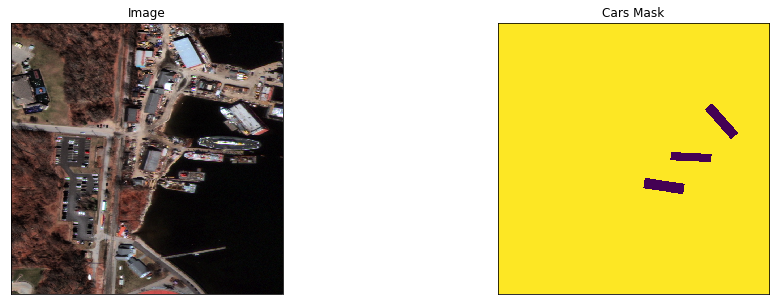

In [211]:
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze()
)

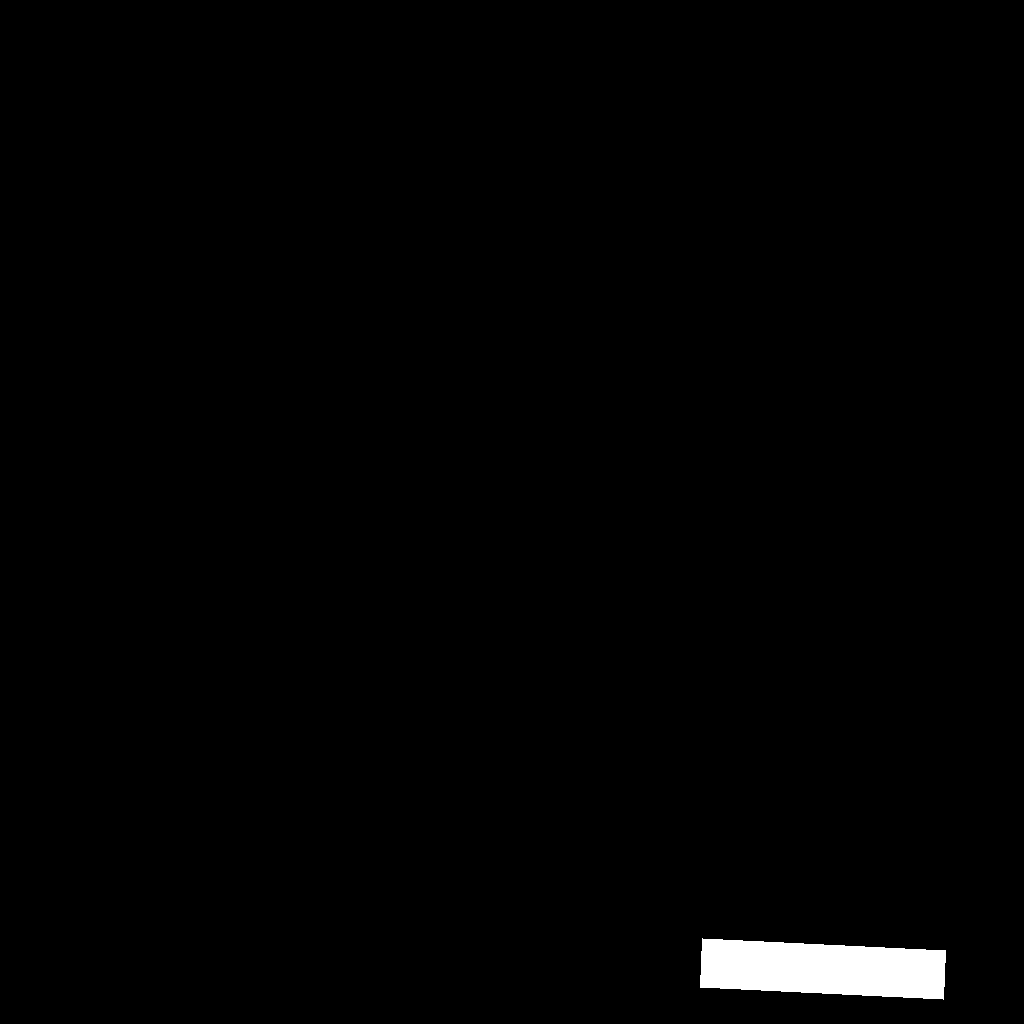

In [111]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['container', 'oil tanker', 'aircraft carrier', 'maritime vessels']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   